In [66]:
import pandas as pd
import json
from tqdm import tqdm
import re
import string
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly import tools
from matplotlib import rcParams
import seaborn as sns

from sklearn import preprocessing
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from textblob import TextBlob
from collections import defaultdict
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy import interp
from itertools import cycle

In [7]:
file_path = "../../data/Electronics.jsonl"

In [8]:
num_lines = sum(1 for line in open(file_path))
print(f'Num. of samples in dataset: {num_lines:,}')

Num. of samples in dataset: 43,886,944


In [9]:
chunksize = 100000
chunks = pd.read_json(file_path, lines=True, chunksize=chunksize)

In [10]:
for c in chunks:
    sample_train_df = c
    break

In [11]:
sample_train_df.head()

rating                                        title  \
0       3            Smells like gasoline! Going back!   
1       1      Didn’t work at all lenses loose/broken.   
2       5                                   Excellent!   
3       5                       Great laptop backpack!   
4       5  Best Headphones in the Fifties price range!   

                                                text  \
0  First & most offensive: they reek of gasoline ...   
1  These didn’t work. Idk if they were damaged in...   
2  I love these. They even come with a carry case...   
3  I was searching for a sturdy backpack for scho...   
4  I've bought these headphones three times becau...   

                                              images        asin parent_asin  \
0  [{'small_image_url': 'https://m.media-amazon.c...  B083NRGZMM  B083NRGZMM   
1                                                 []  B07N69T6TM  B07N69T6TM   
2                                                 []  B01G8JO5F2  B01G8JO5F2   
3                                                 []  B001OC5JKY  B001OC5JKY   
4                                                 []  B013J7WUGC  B07CJYMRWM   

                        user_id               timestamp  helpful_vote  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2022-07-18 22:58:37.948             0   
1  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2020-06-20 18:42:29.731             0   
2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2018-04-07 09:23:37.534             0   
3  AGGZ357AO26RQZVRLGU4D4N52DZQ 2010-11-20 18:41:35.000            18   
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA 2023-02-17 02:39:41.238             0   

   verified_purchase  
0               True  
1               True  
2               True  
3               True  
4               True

In [12]:
sample_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             100000 non-null  int64         
 1   title              100000 non-null  object        
 2   text               100000 non-null  object        
 3   images             100000 non-null  object        
 4   asin               100000 non-null  object        
 5   parent_asin        100000 non-null  object        
 6   user_id            100000 non-null  object        
 7   timestamp          100000 non-null  datetime64[ns]
 8   helpful_vote       100000 non-null  int64         
 9   verified_purchase  100000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 7.0+ MB


In [13]:
process_reviews=sample_train_df.copy()

process_reviews.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [14]:
process_reviews['reviews']=process_reviews['title'] + " " + process_reviews['text']
process_reviews=process_reviews.drop(['title', 'text'], axis=1)
process_reviews.head()

rating                                             images        asin  \
0       3  [{'small_image_url': 'https://m.media-amazon.c...  B083NRGZMM   
1       1                                                 []  B07N69T6TM   
2       5                                                 []  B01G8JO5F2   
3       5                                                 []  B001OC5JKY   
4       5                                                 []  B013J7WUGC   

  parent_asin                       user_id               timestamp  \
0  B083NRGZMM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2022-07-18 22:58:37.948   
1  B07N69T6TM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2020-06-20 18:42:29.731   
2  B01G8JO5F2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2018-04-07 09:23:37.534   
3  B001OC5JKY  AGGZ357AO26RQZVRLGU4D4N52DZQ 2010-11-20 18:41:35.000   
4  B07CJYMRWM  AG2L7H23R5LLKDKLBEF2Q3L2MVDA 2023-02-17 02:39:41.238   

   helpful_vote  verified_purchase  \
0             0               True   
1             0               True   
2             0               True   
3            18               True   
4             0               True   

                                             reviews  
0  Smells like gasoline! Going back! First & most...  
1  Didn’t work at all lenses loose/broken. These ...  
2  Excellent! I love these. They even come with a...  
3  Great laptop backpack! I was searching for a s...  
4  Best Headphones in the Fifties price range! I'...

In [15]:
process_reviews['rating'].value_counts()

rating
5    65371
4    15191
1     8006
3     7131
2     4301
Name: count, dtype: int64

In [16]:
def get_sentiment(row):
    if row['rating'] == 3.0:
        val = 'Neutral'
    elif row['rating'] == 1.0 or row['rating'] == 2.0:
        val = 'Negative'
    elif row['rating'] == 4.0 or row['rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [17]:
process_reviews['sentiment'] = process_reviews.apply(get_sentiment, axis=1)
process_reviews.head()

rating                                             images        asin  \
0       3  [{'small_image_url': 'https://m.media-amazon.c...  B083NRGZMM   
1       1                                                 []  B07N69T6TM   
2       5                                                 []  B01G8JO5F2   
3       5                                                 []  B001OC5JKY   
4       5                                                 []  B013J7WUGC   

  parent_asin                       user_id               timestamp  \
0  B083NRGZMM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2022-07-18 22:58:37.948   
1  B07N69T6TM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2020-06-20 18:42:29.731   
2  B01G8JO5F2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2018-04-07 09:23:37.534   
3  B001OC5JKY  AGGZ357AO26RQZVRLGU4D4N52DZQ 2010-11-20 18:41:35.000   
4  B07CJYMRWM  AG2L7H23R5LLKDKLBEF2Q3L2MVDA 2023-02-17 02:39:41.238   

   helpful_vote  verified_purchase  \
0             0               True   
1             0               True   
2             0               True   
3            18               True   
4             0               True   

                                             reviews sentiment  
0  Smells like gasoline! Going back! First & most...   Neutral  
1  Didn’t work at all lenses loose/broken. These ...  Negative  
2  Excellent! I love these. They even come with a...  Positive  
3  Great laptop backpack! I was searching for a s...  Positive  
4  Best Headphones in the Fifties price range! I'...  Positive

In [18]:
process_reviews['sentiment'].value_counts()

sentiment
Positive    80562
Negative    12307
Neutral      7131
Name: count, dtype: int64

In [19]:
process_reviews["year"]= process_reviews["timestamp"].dt.year

process_reviews["month"]= process_reviews["timestamp"].dt.month

process_reviews["day"]= process_reviews["timestamp"].dt.day

In [20]:
process_reviews=process_reviews.drop(['timestamp'], axis=1)
process_reviews.head()

rating                                             images        asin  \
0       3  [{'small_image_url': 'https://m.media-amazon.c...  B083NRGZMM   
1       1                                                 []  B07N69T6TM   
2       5                                                 []  B01G8JO5F2   
3       5                                                 []  B001OC5JKY   
4       5                                                 []  B013J7WUGC   

  parent_asin                       user_id  helpful_vote  verified_purchase  \
0  B083NRGZMM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0               True   
1  B07N69T6TM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0               True   
2  B01G8JO5F2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0               True   
3  B001OC5JKY  AGGZ357AO26RQZVRLGU4D4N52DZQ            18               True   
4  B07CJYMRWM  AG2L7H23R5LLKDKLBEF2Q3L2MVDA             0               True   

                                             reviews sentiment  year  month  \
0  Smells like gasoline! Going back! First & most...   Neutral  2022      7   
1  Didn’t work at all lenses loose/broken. These ...  Negative  2020      6   
2  Excellent! I love these. They even come with a...  Positive  2018      4   
3  Great laptop backpack! I was searching for a s...  Positive  2010     11   
4  Best Headphones in the Fifties price range! I'...  Positive  2023      2   

   day  
0   18  
1   20  
2    7  
3   20  
4   17

In [21]:
process_reviews['helpful_vote'].value_counts()

helpful_vote
0      74409
1      12365
2       4437
3       2152
4       1376
       ...  
200        1
130        1
451        1
289        1
645        1
Name: count, Length: 215, dtype: int64

In [22]:
process_reviews['verified_purchase'].value_counts()

verified_purchase
True     78983
False    21017
Name: count, dtype: int64

In [23]:
process_reviews=process_reviews.drop(['images','asin','verified_purchase'], axis=1)

clean_reviews=process_reviews.copy()

In [24]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [25]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

rating parent_asin                       user_id  helpful_vote  \
0       3  B083NRGZMM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
1       1  B07N69T6TM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
2       5  B01G8JO5F2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
3       5  B001OC5JKY  AGGZ357AO26RQZVRLGU4D4N52DZQ            18   
4       5  B07CJYMRWM  AG2L7H23R5LLKDKLBEF2Q3L2MVDA             0   

                                             reviews sentiment  year  month  \
0  smells like gasoline going back first  most of...   Neutral  2022      7   
1  didn’t work at all lenses loosebroken these di...  Negative  2020      6   
2  excellent i love these they even come with a c...  Positive  2018      4   
3  great laptop backpack i was searching for a st...  Positive  2010     11   
4  best headphones in the fifties price range ive...  Positive  2023      2   

   day  
0   18  
1   20  
2    7  
3   20  
4   17

In [26]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't",
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [27]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

rating parent_asin                       user_id  helpful_vote  \
0       3  B083NRGZMM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
1       1  B07N69T6TM  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
2       5  B01G8JO5F2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ             0   
3       5  B001OC5JKY  AGGZ357AO26RQZVRLGU4D4N52DZQ            18   
4       5  B07CJYMRWM  AG2L7H23R5LLKDKLBEF2Q3L2MVDA             0   

                                             reviews sentiment  year  month  \
0  smells like gasoline going back first offensiv...   Neutral  2022      7   
1  didn’t work lenses loosebroken didn’t work idk...  Negative  2020      6   
2  excellent love even come carry case several si...  Positive  2018      4   
3  great laptop backpack searching sturdy backpac...  Positive  2010     11   
4  best headphones fifties price range ive bought...  Positive  2023      2   

   day  
0   18  
1   20  
2    7  
3   20  
4   17

In [28]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_vote'].mean())

helpful_vote
sentiment              
Negative       1.732104
Neutral        1.453513
Positive       1.585971

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



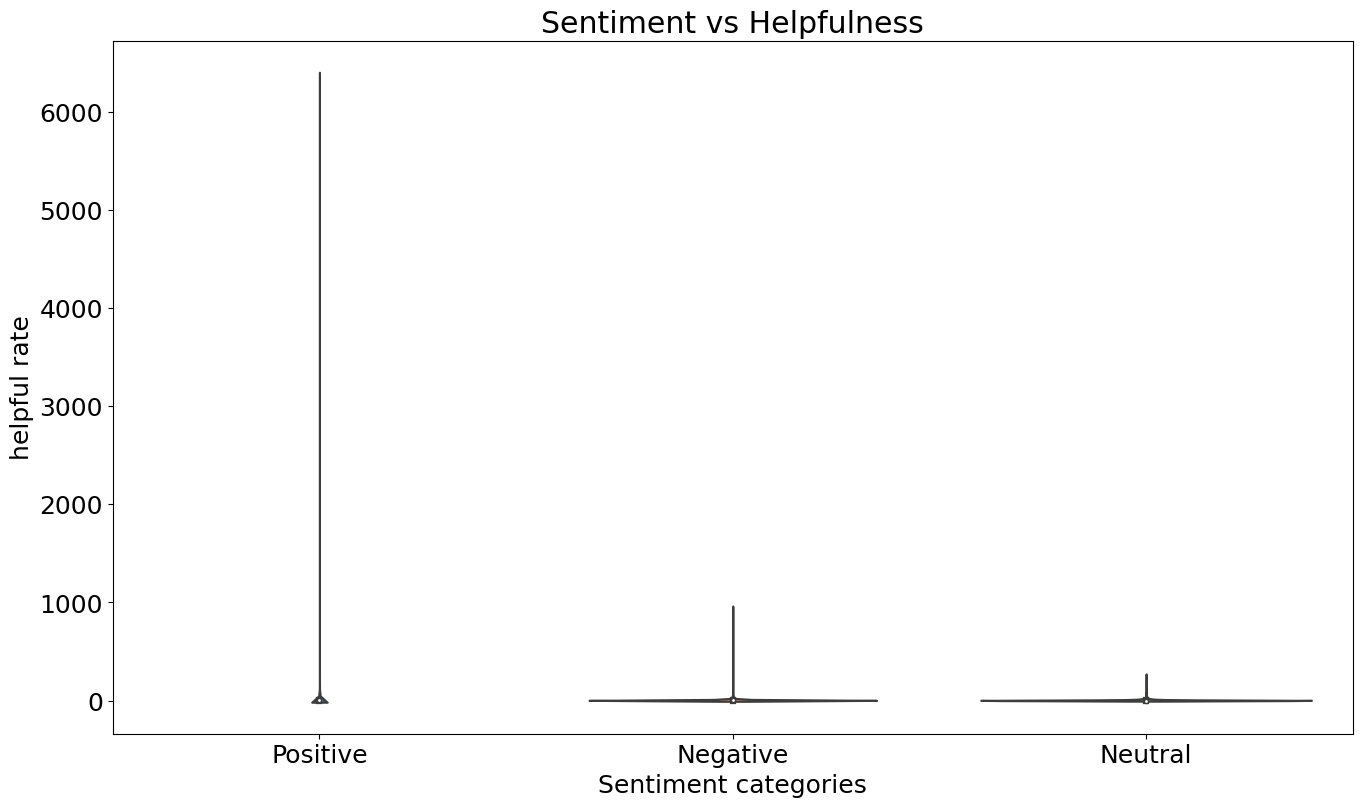

In [29]:
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_vote'])
senti_help = senti_help[senti_help['helpful_vote'] != 0.00]

sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_vote"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

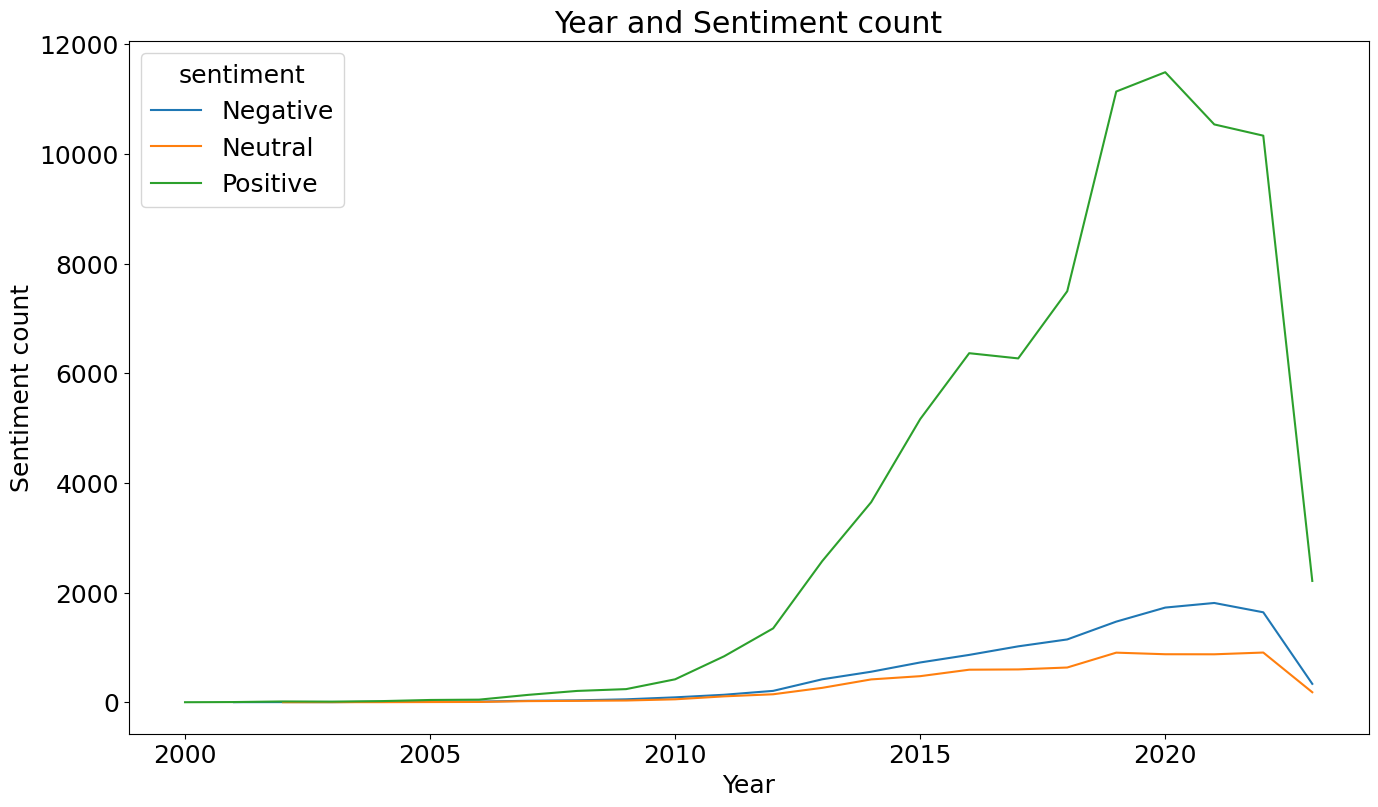

In [30]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



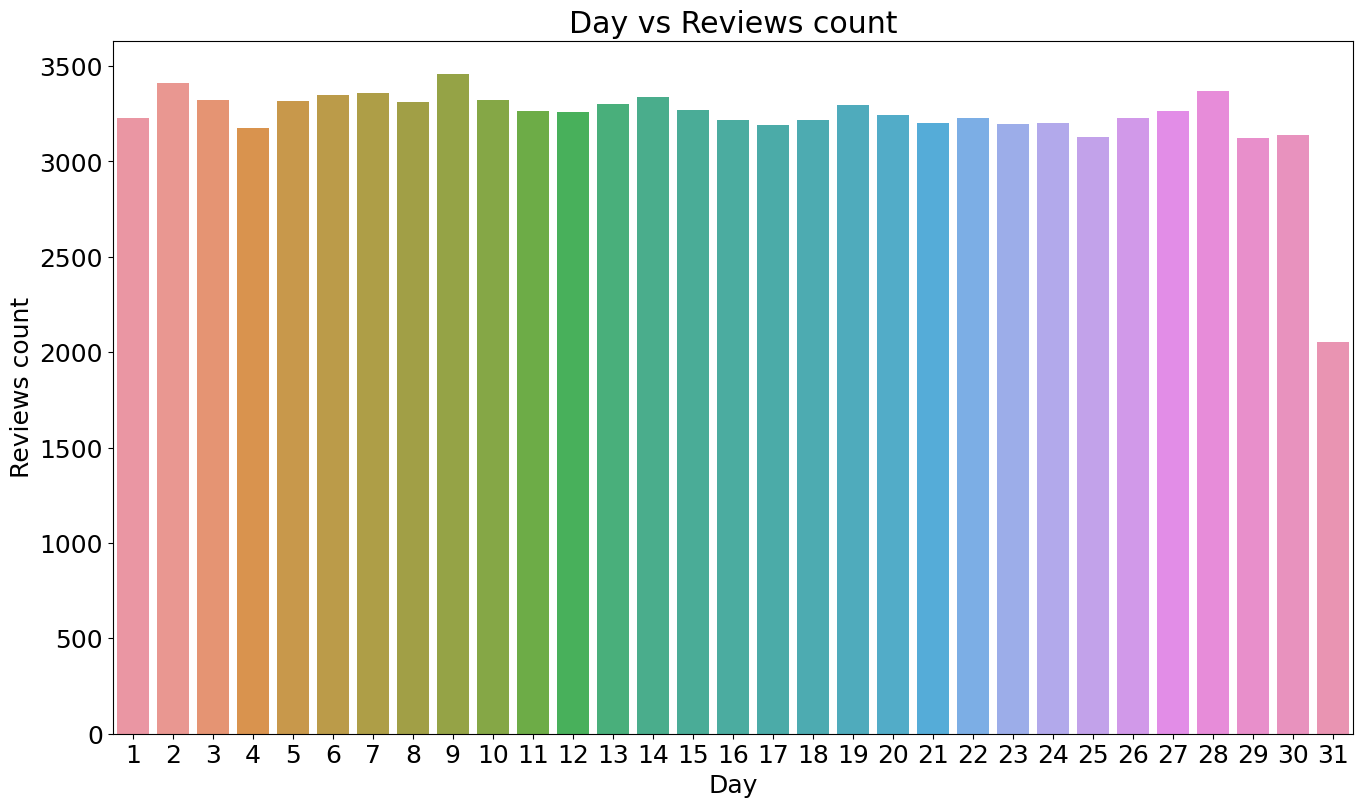

In [31]:
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

In [32]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [33]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

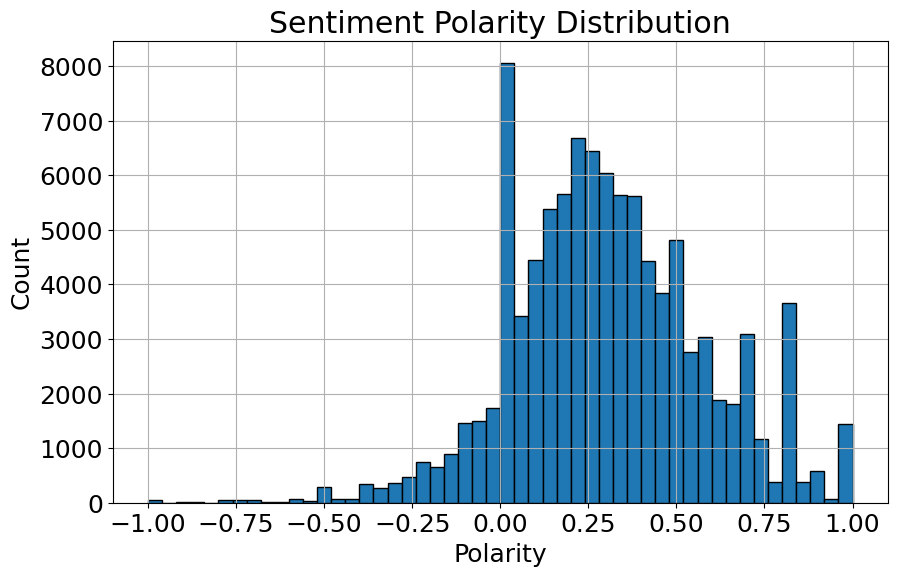

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(process_reviews['polarity'], bins=50, edgecolor='black')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Sentiment Polarity Distribution')
plt.grid(True)
plt.show()

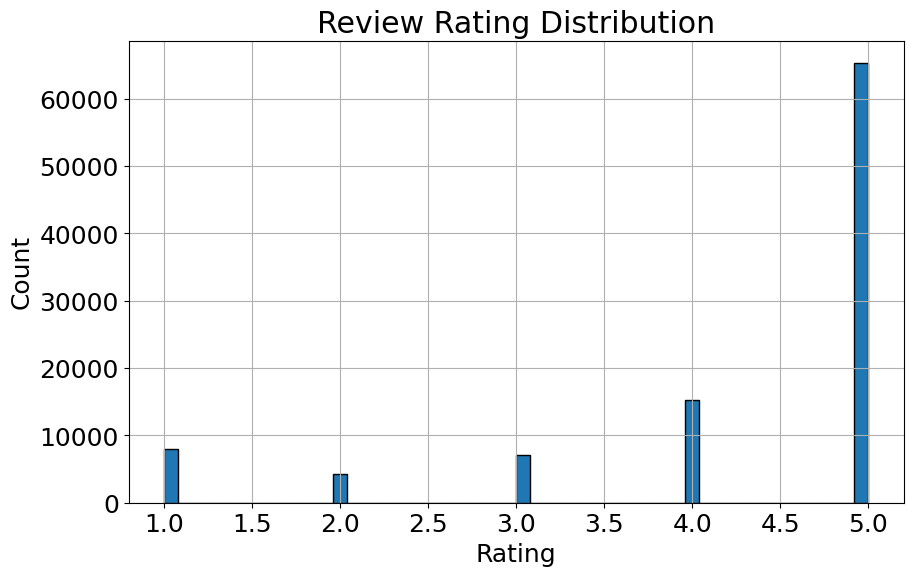

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(process_reviews['rating'], bins=50, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Review Rating Distribution')
plt.grid(True)
plt.show()

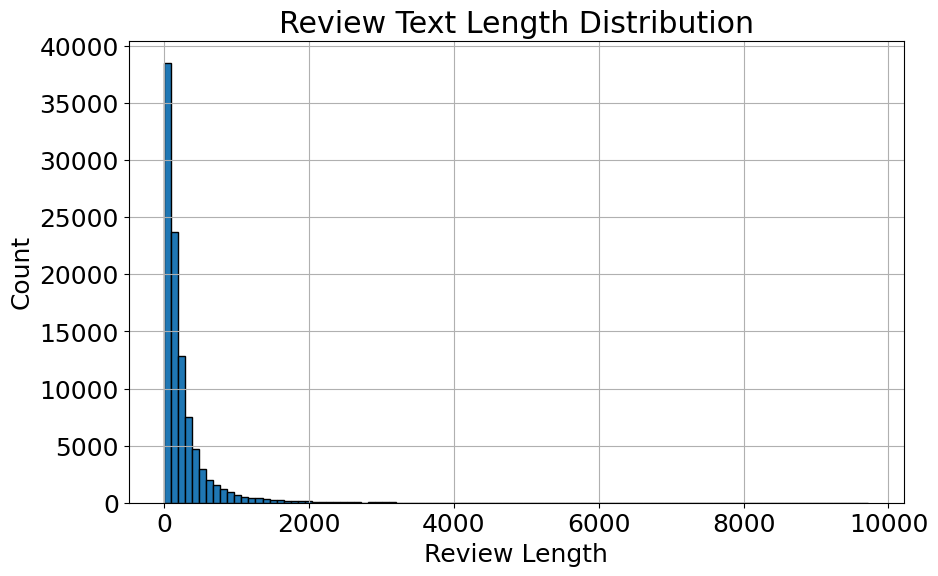

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(process_reviews['review_len'], bins=100, edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Review Text Length Distribution')
plt.grid(True)
plt.show()

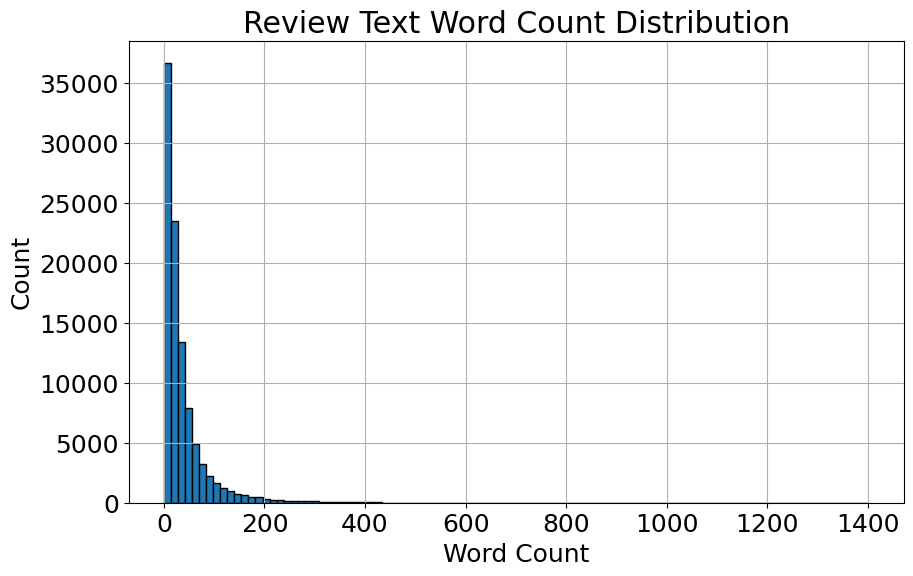

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(process_reviews['word_count'], bins=100, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Review Text Word Count Distribution')
plt.grid(True)
plt.show()

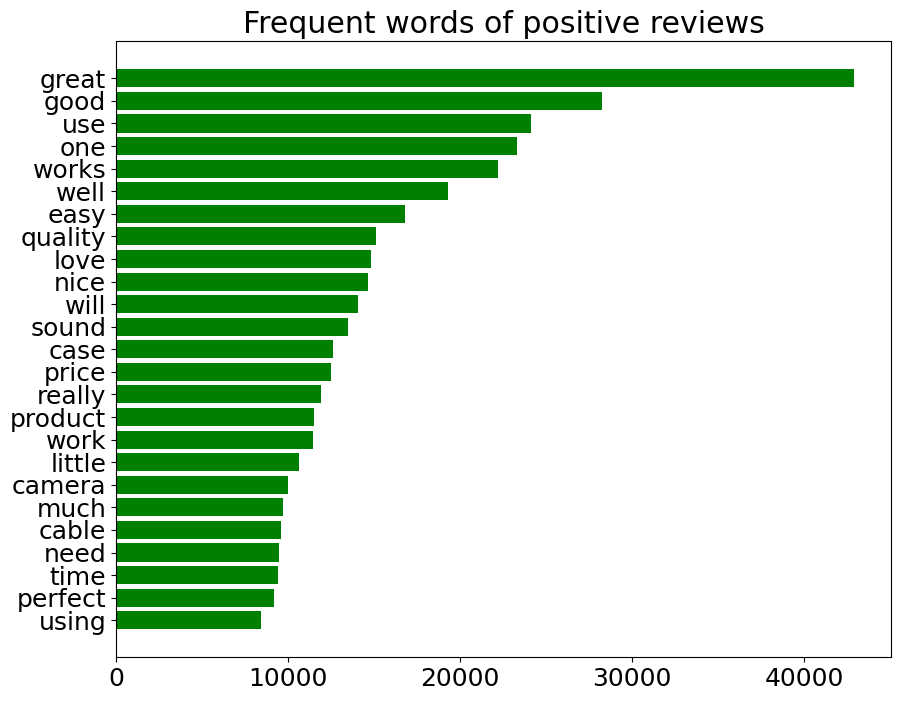

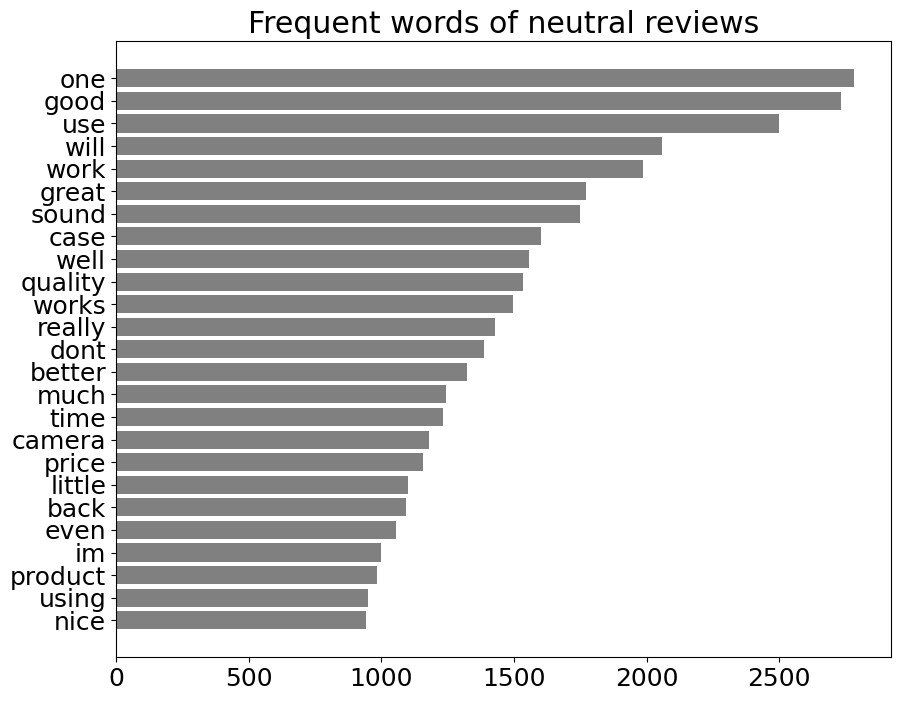

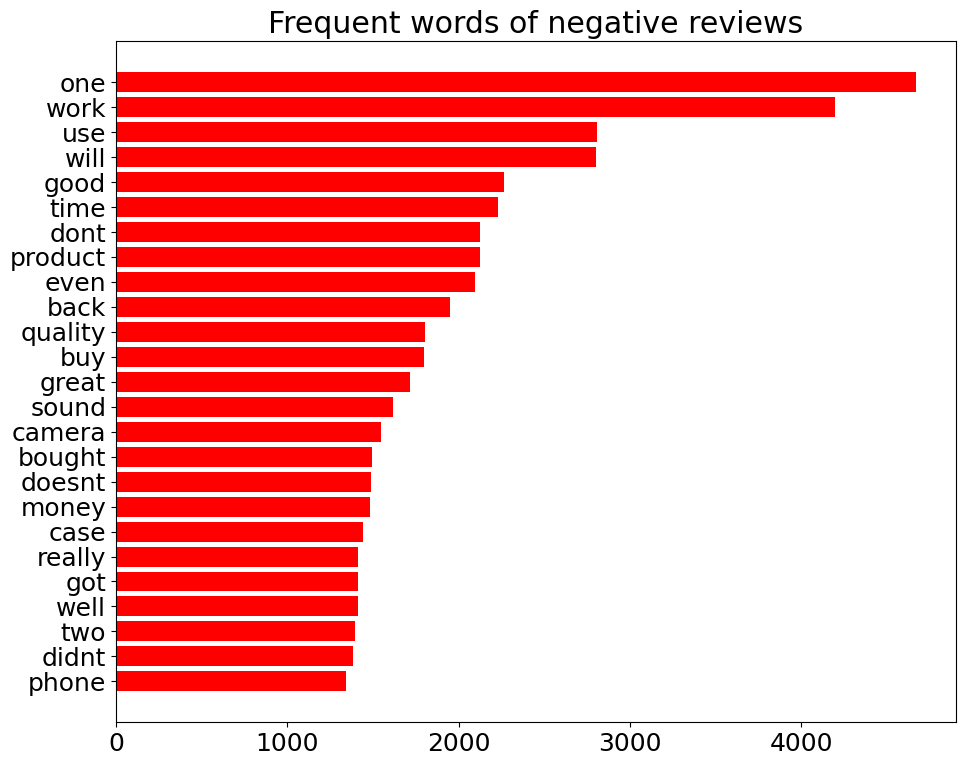

In [38]:
#Filtering
review_pos = process_reviews[process_reviews["sentiment"] == 'Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"] == 'Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"] == 'Negative'].dropna()


def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


def horizontal_bar_chart(ax, df, color):
    ax.barh(df["word"], df["wordcount"], color=color)
    ax.invert_yaxis()

#  positive 
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax1 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax1, pd.DataFrame({"word": words, "wordcount": counts}), 'green')
ax1.set_title('Frequent words of positive reviews')

#  neutral 
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax2 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax2, pd.DataFrame({"word": words, "wordcount": counts}), 'grey')
ax2.set_title('Frequent words of neutral reviews')

#  negative 
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax3 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax3, pd.DataFrame({"word": words, "wordcount": counts}), 'red')
ax3.set_title('Frequent words of negative reviews')

plt.tight_layout()
plt.show()

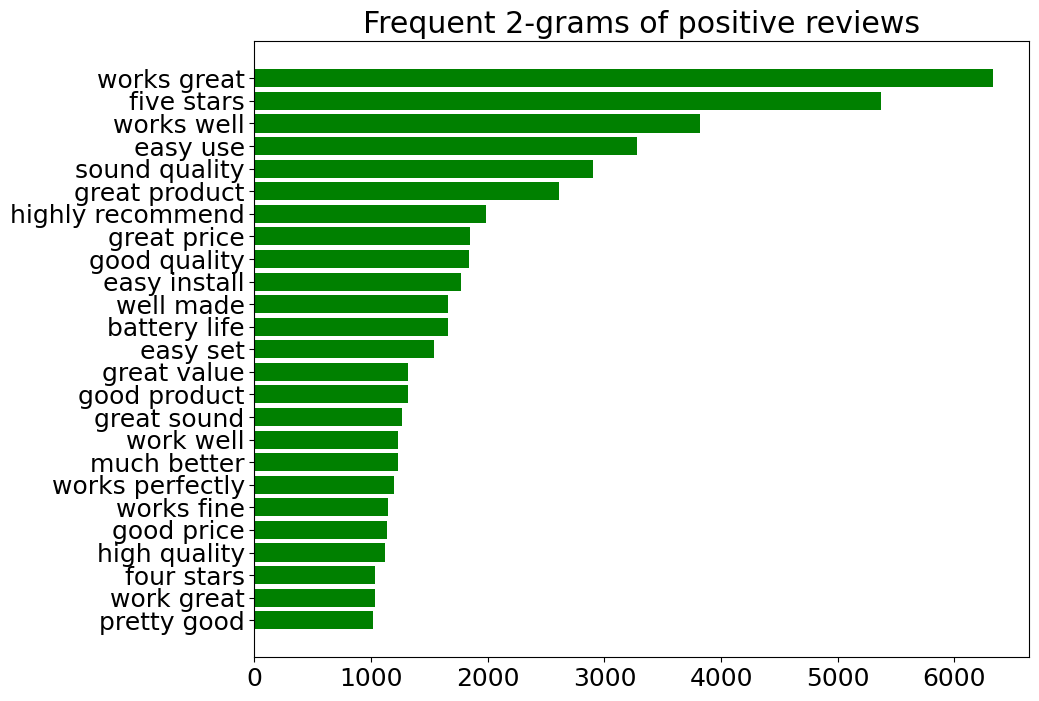

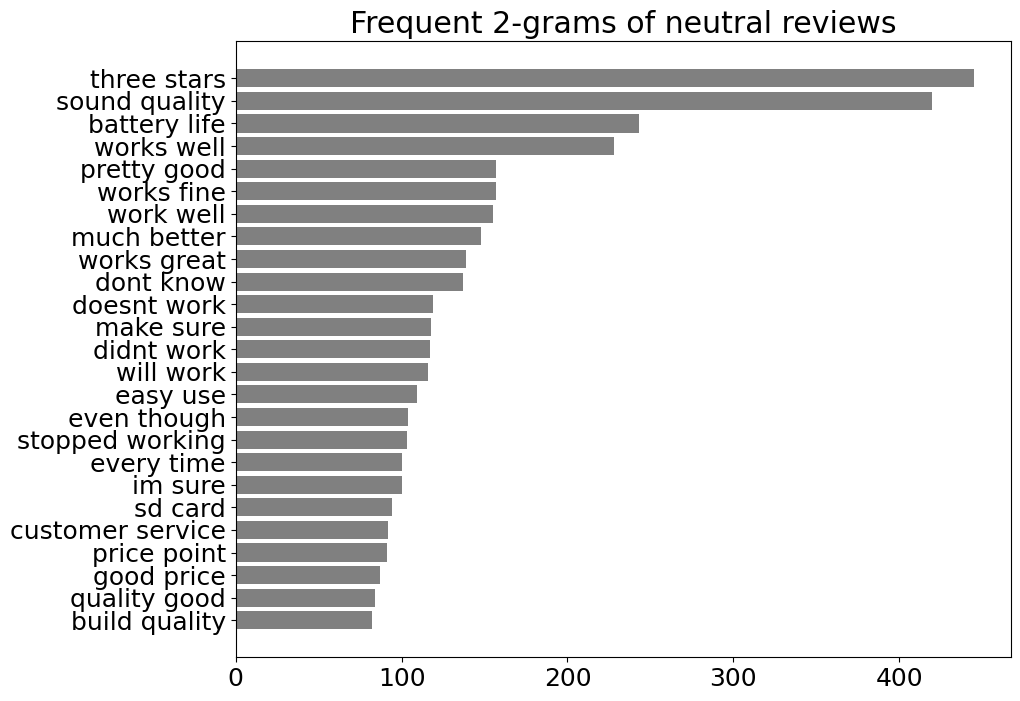

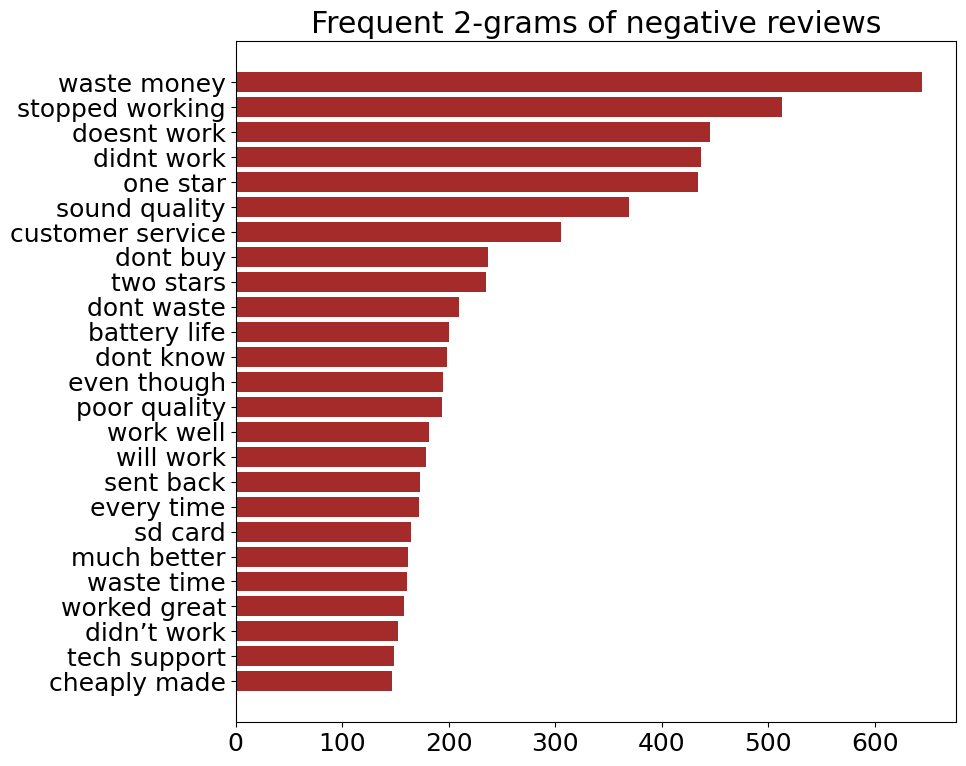

In [39]:
##  positive 
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax1 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax1, pd.DataFrame({"word": words, "wordcount": counts}), 'green')
ax1.set_title('Frequent 2-grams of positive reviews')

##  neutral 
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax2 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax2, pd.DataFrame({"word": words, "wordcount": counts}), 'grey')
ax2.set_title('Frequent 2-grams of neutral reviews')

##  negative 
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax3 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax3, pd.DataFrame({"word": words, "wordcount": counts}), 'brown')
ax3.set_title('Frequent 2-grams of negative reviews')

plt.tight_layout()
plt.show()

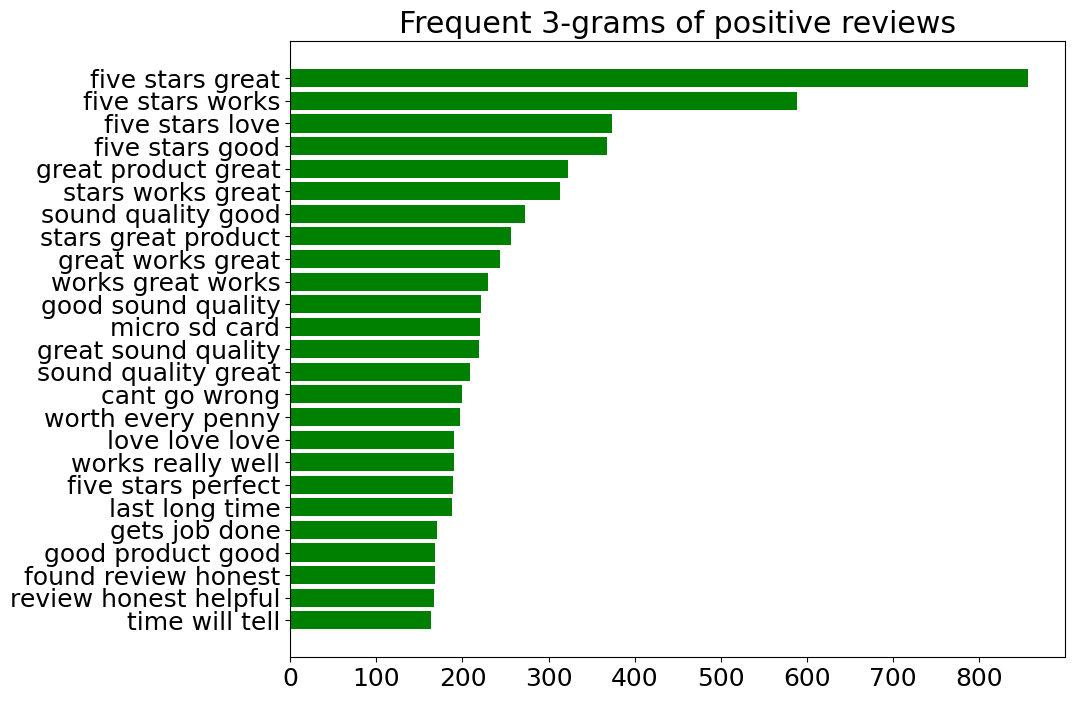

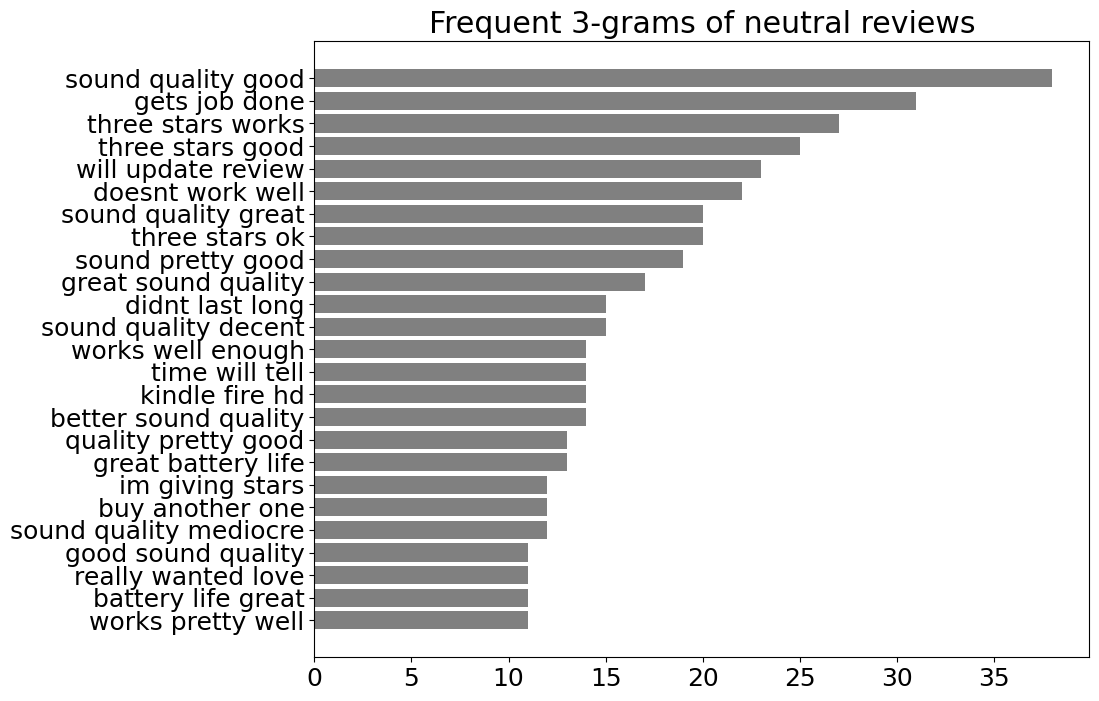

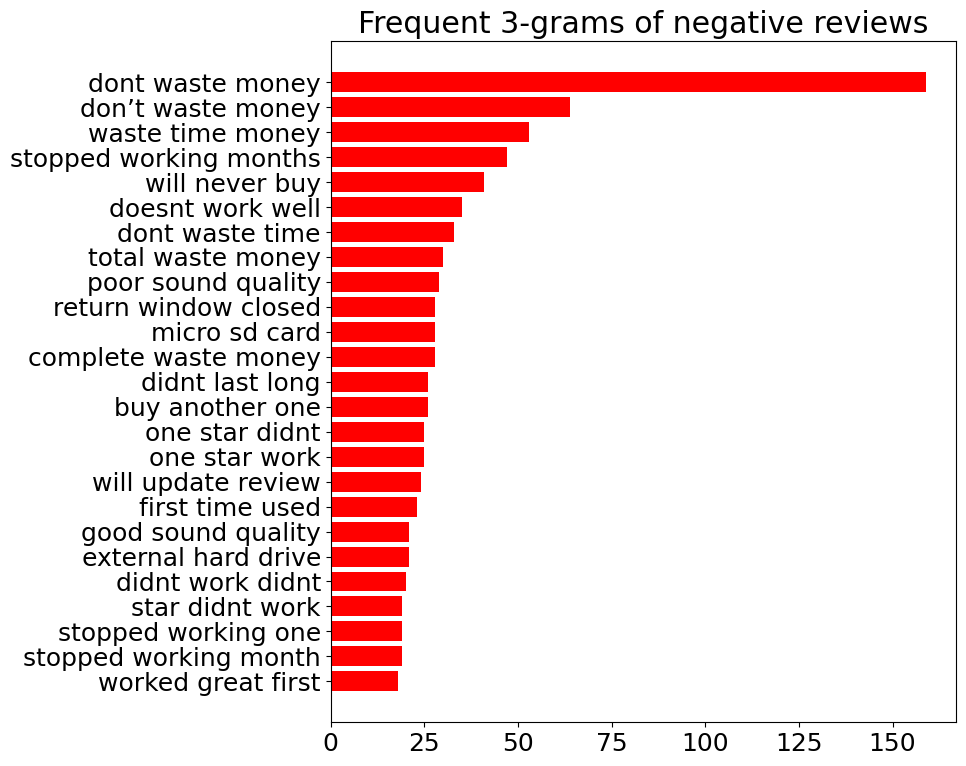

In [40]:
##  positive 
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax1 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax1, pd.DataFrame({"word": words, "wordcount": counts}), 'green')
ax1.set_title('Frequent 3-grams of positive reviews')

##  neutral #
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax2 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax2, pd.DataFrame({"word": words, "wordcount": counts}), 'grey')
ax2.set_title('Frequent 3-grams of neutral reviews')

##  negative 
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25]
words, counts = zip(*fd_sorted)
fig, ax3 = plt.subplots(figsize=(10, 8))
horizontal_bar_chart(ax3, pd.DataFrame({"word": words, "wordcount": counts}), 'red')
ax3.set_title('Frequent 3-grams of negative reviews')

plt.tight_layout()
plt.show()

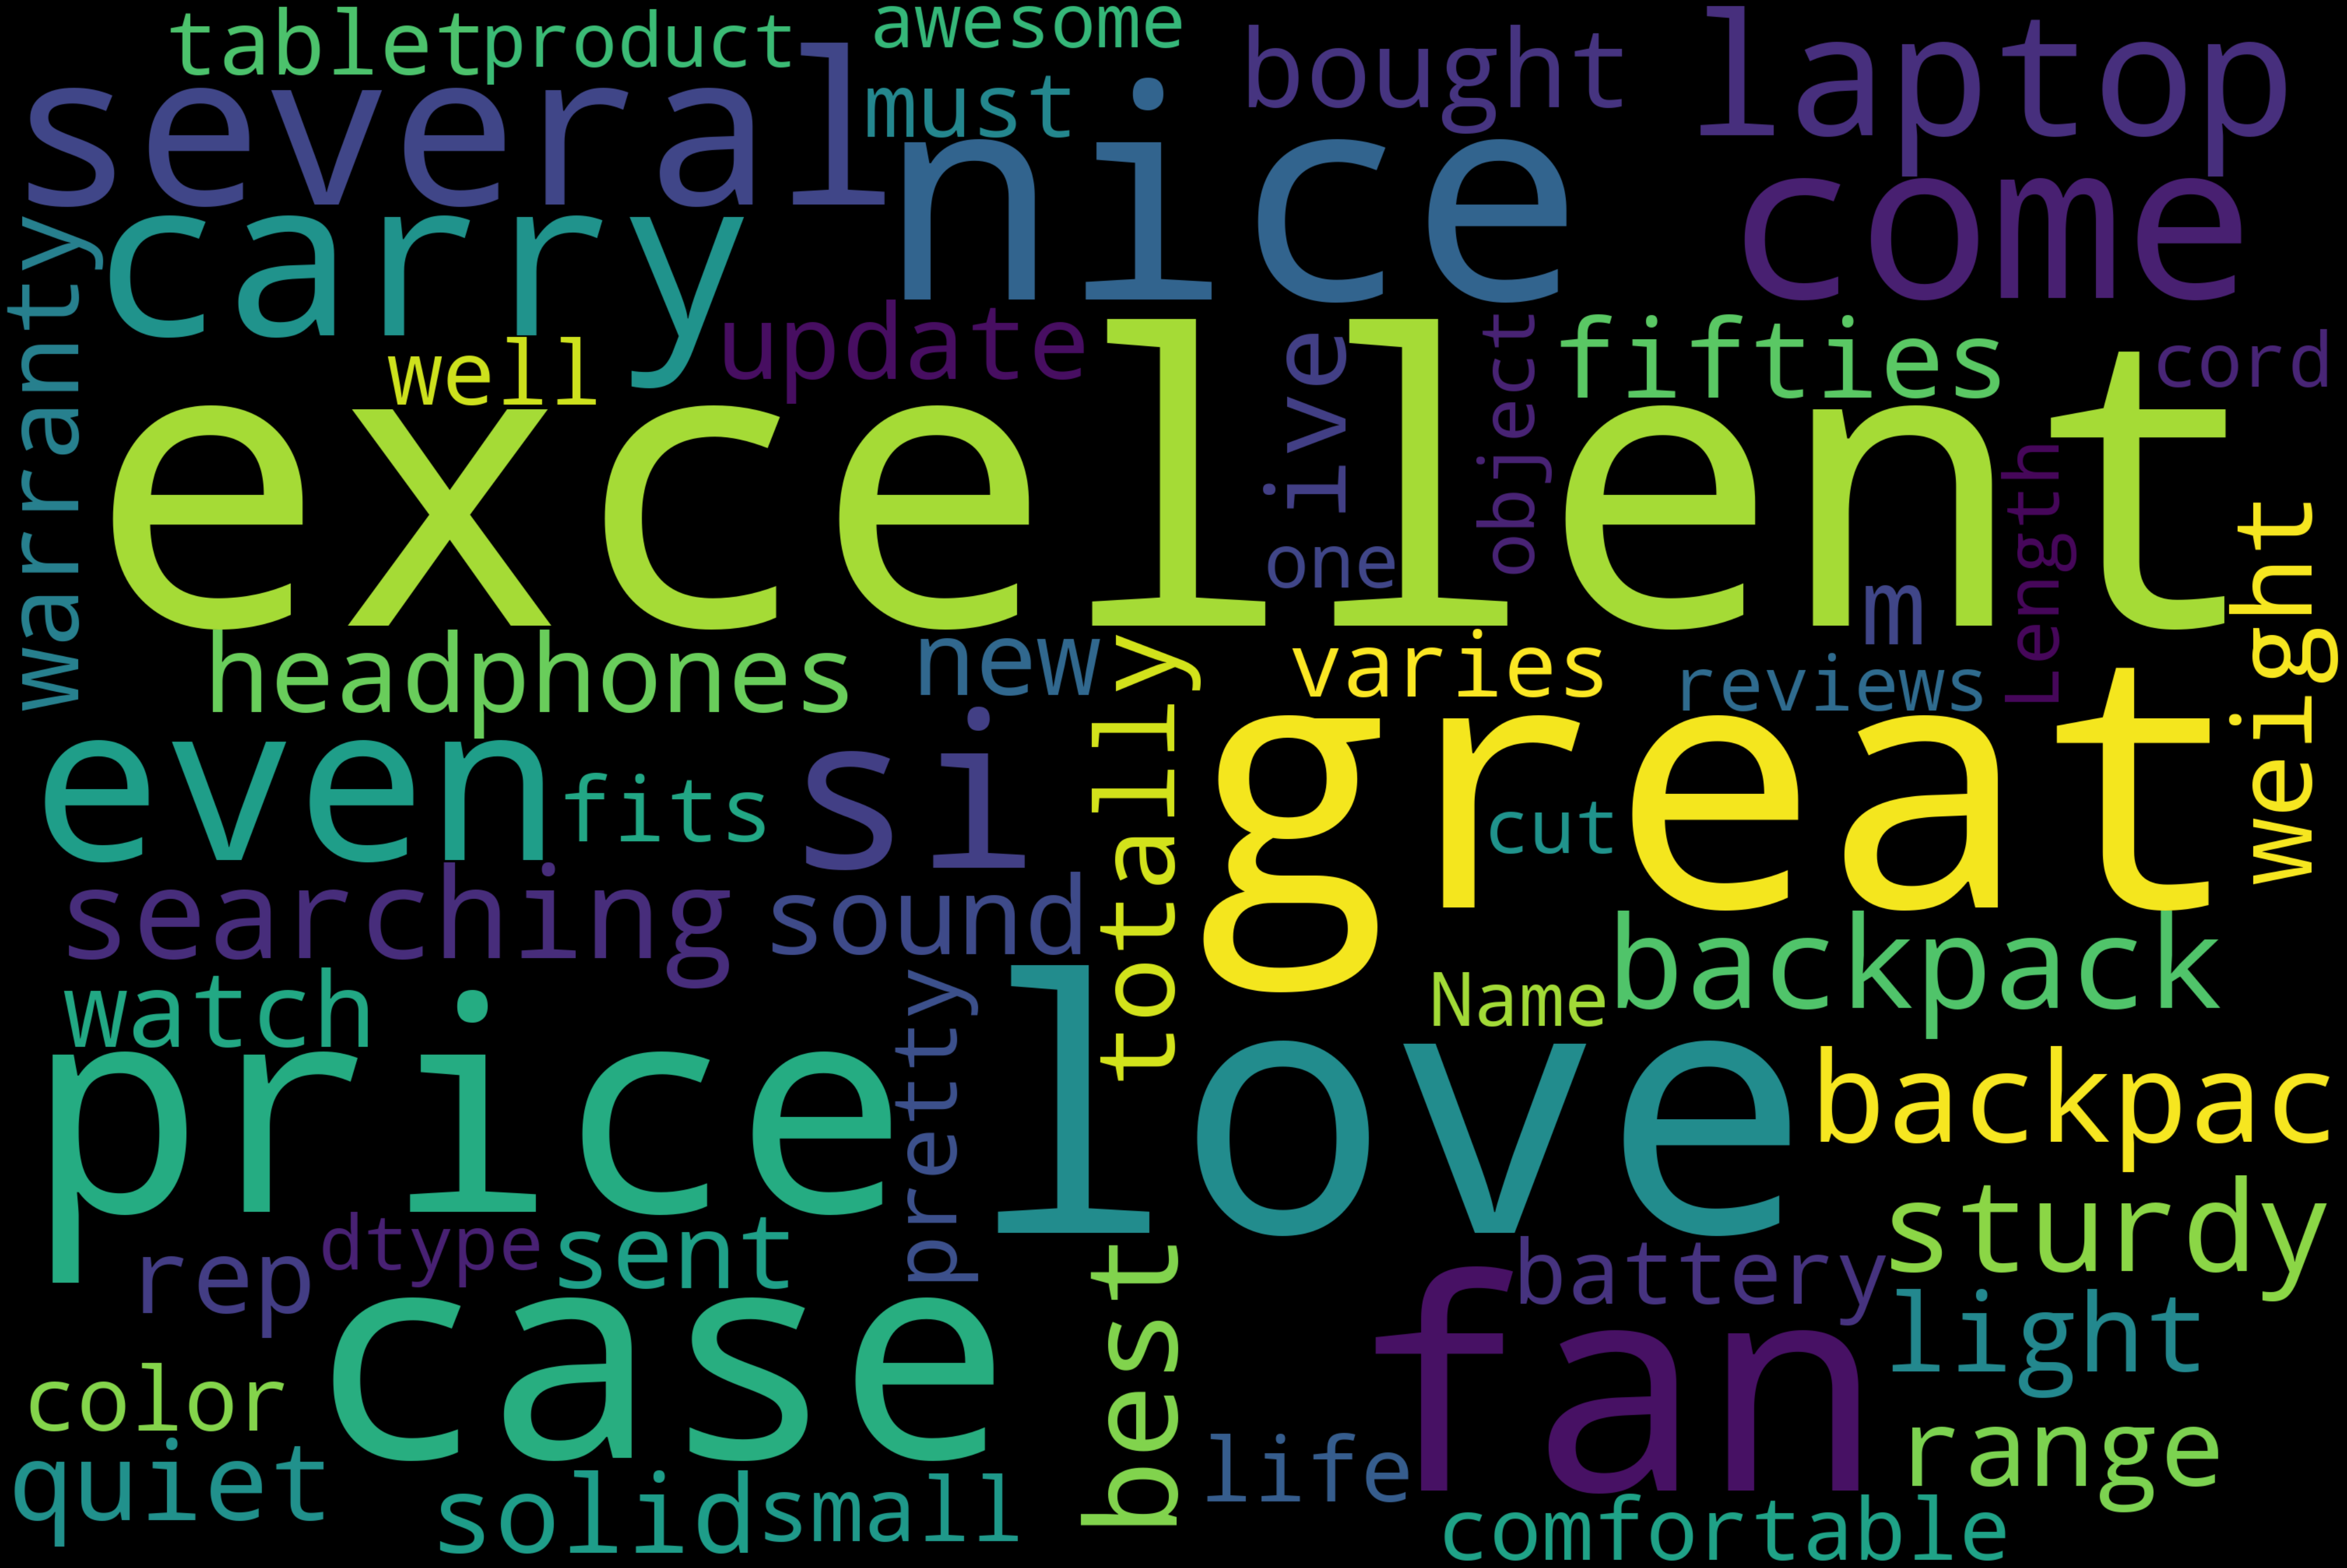

In [41]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

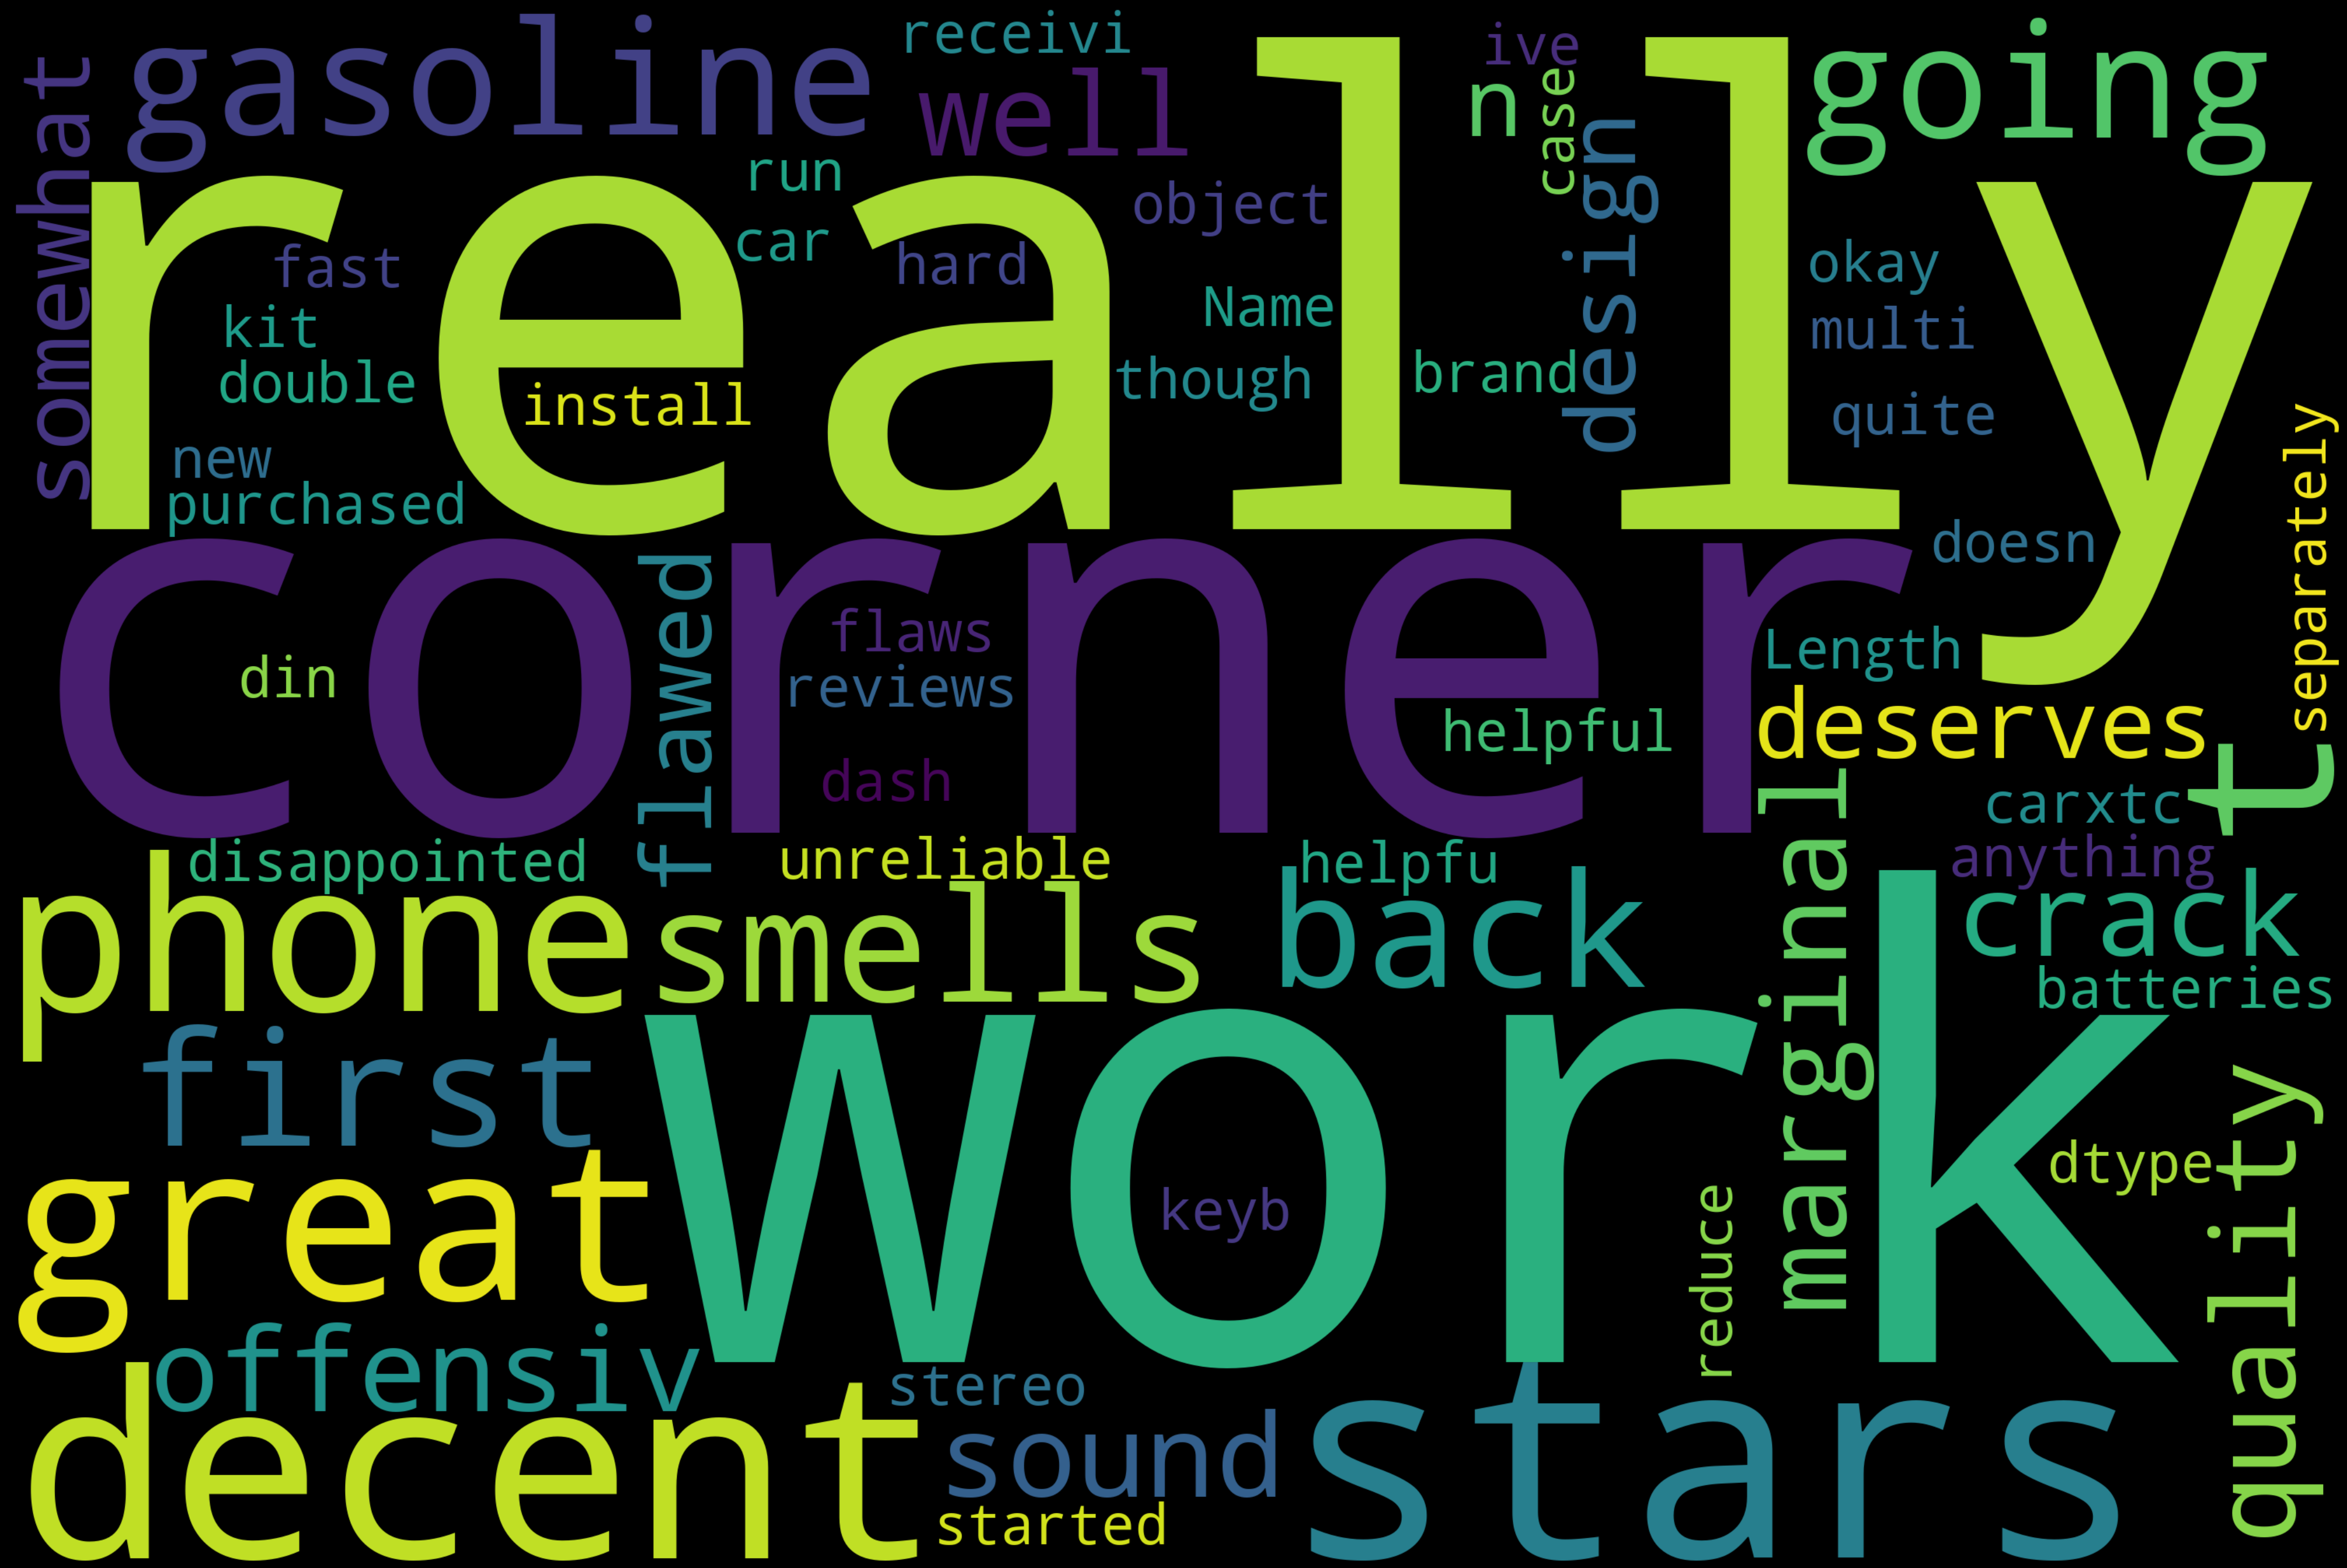

In [42]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

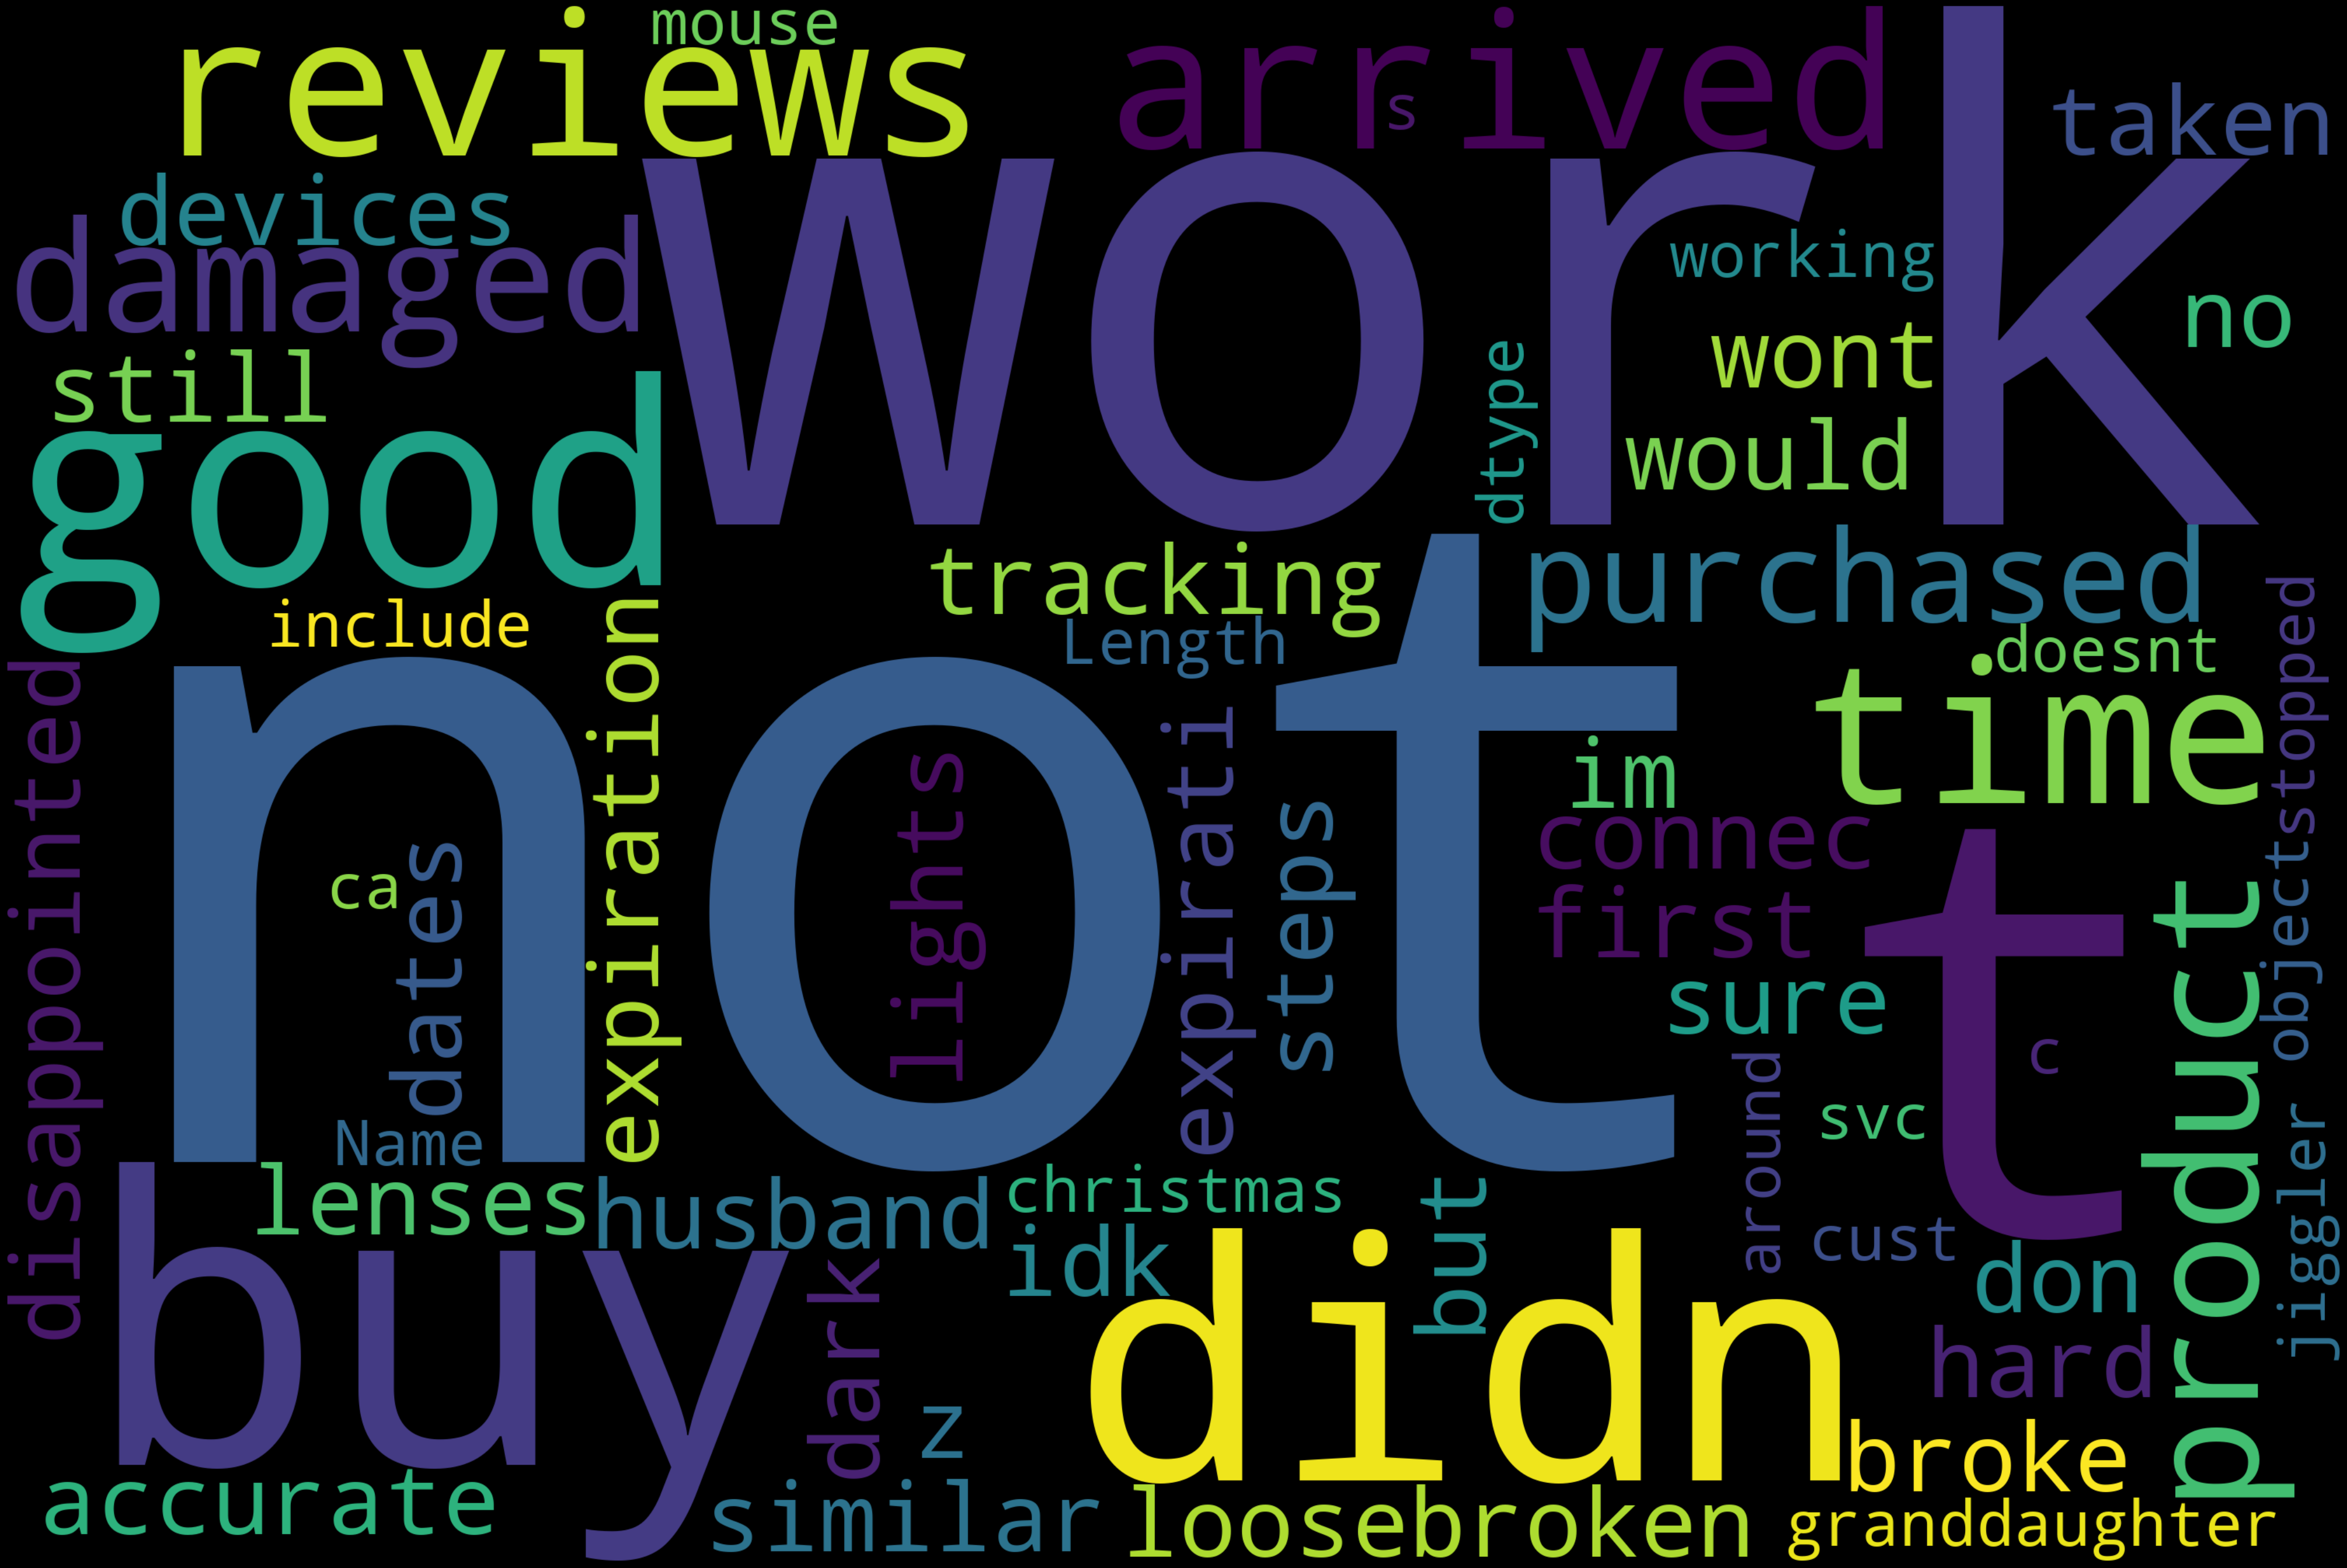

In [43]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [44]:
label_encoder = preprocessing.LabelEncoder()

# Encode 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment'])

process_reviews['sentiment'].unique()

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



array([1, 0, 2])

In [85]:
np.save('classes.npy', label_encoder.classes_)

In [45]:
process_reviews['sentiment'].value_counts()

sentiment
2    80562
0    12307
1     7131
Name: count, dtype: int64

In [46]:
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  smells like gasoline going back first offensiv...
1  didn’t work lenses loosebroken didn’t work idk...
2  excellent love even come carry case several si...
3  great laptop backpack searching sturdy backpac...
4  best headphones fifties price range ive bought...

In [47]:
ps = PorterStemmer()


corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [48]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF 
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [49]:
X.shape

(100000, 5000)

In [50]:
y=process_reviews['sentiment']

In [51]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 80562, 0: 12307, 1: 7131})


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

Resampled dataset shape Counter({1: 80562, 0: 80562, 2: 80562})


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

Logistic Regression Test Accuracy: 0.8697100000000001


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

Decision Tree Test Accuracy: 0.8187099999999999


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

KNN Test Accuracy: 0.8301000000000001


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

SVC Test Accuracy: 0.86799
Naive Bayes Test Accuracy: 0.8194799999999999


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

In [56]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

LogisticRegression(C=159.98587196060572, random_state=0)
The mean accuracy of the model is: 0.7717718711727517


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\valida

In [57]:
logreg = LogisticRegression(C=160.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy of logistic regression classifier on test set: 0.77


c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\valida

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

Confusion matrix, without normalization


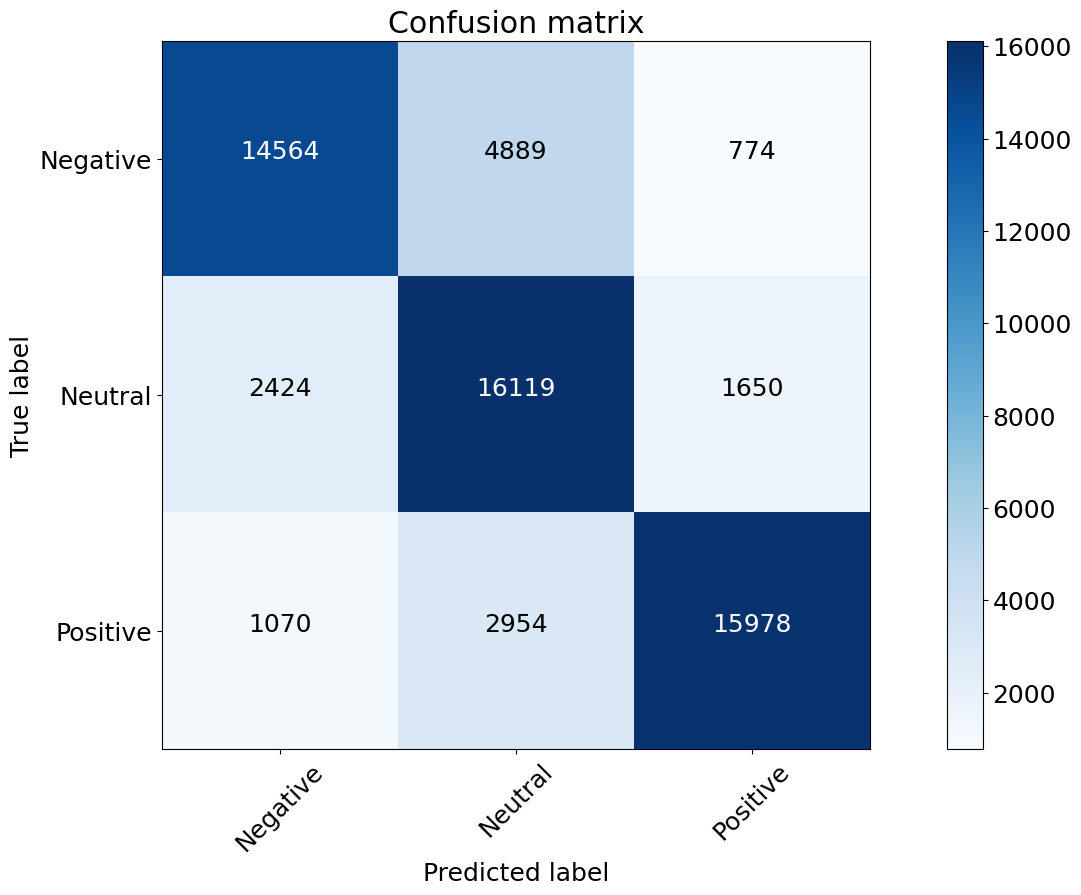

In [59]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [62]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76     20227
           1       0.67      0.80      0.73     20193
           2       0.87      0.80      0.83     20002

    accuracy                           0.77     60422
   macro avg       0.78      0.77      0.77     60422
weighted avg       0.78      0.77      0.77     60422



c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecate

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\artur\AppData\Local\Temp\ipykernel_36792\2179363840.py:32: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



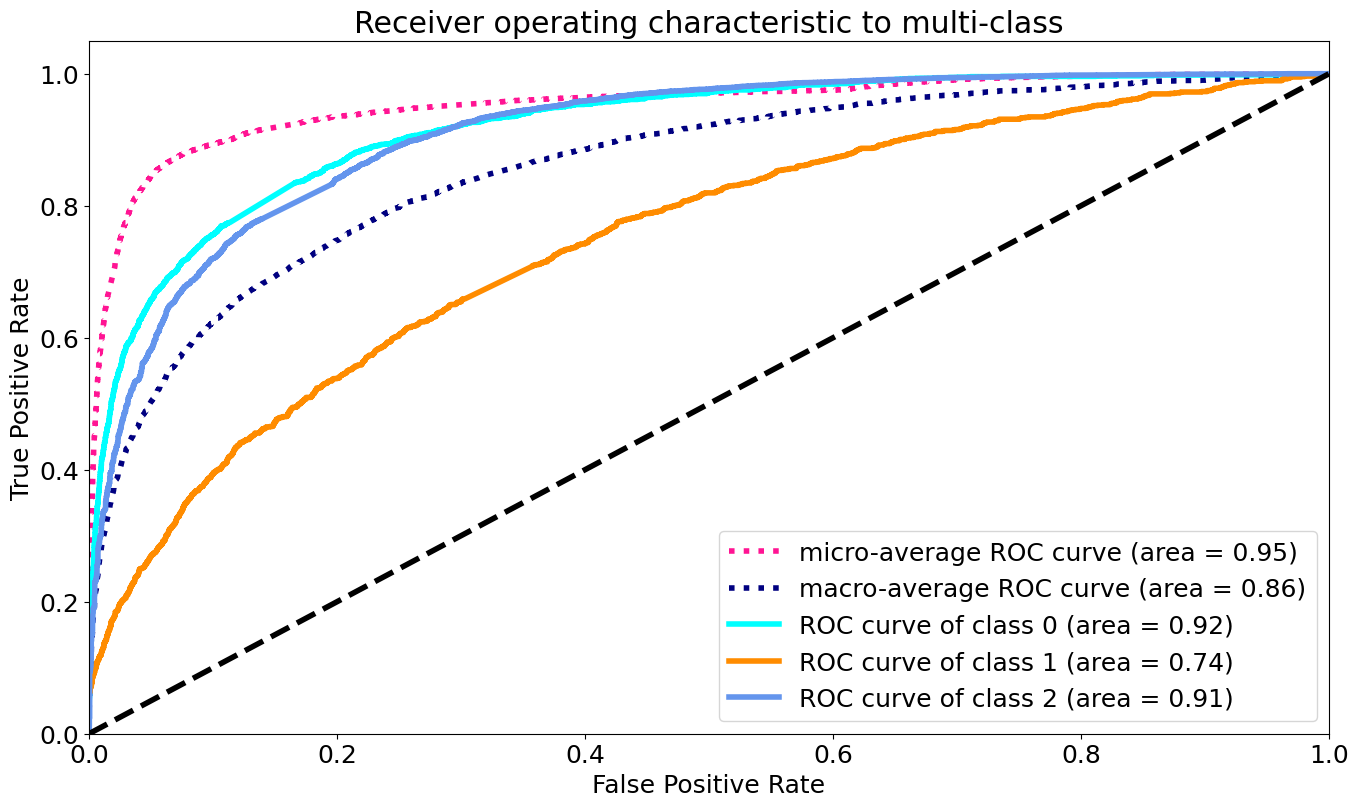

In [67]:
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [69]:
def plot_history(history):
    plt.figure(figsize=(10, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [72]:
NUM_WORDS = 30000
MAX_SEQUENCE_LENGTH = 32
OOV_TOKEN = '<OOV>'
PADDING = 'post'

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(process_reviews['reviews'])
X_seq = tokenizer.texts_to_sequences(process_reviews['reviews'])
X_seq = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=PADDING)

Y_seq = pd.get_dummies(process_reviews['sentiment']).values

X_train_seq, X_test_seq, Y_train_seq, Y_test_seq = train_test_split(X_seq, Y_seq, test_size=0.25, random_state=0)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(process_reviews['sentiment']), y=process_reviews['sentiment'])
class_weights = dict(enumerate(class_weights))
print("class_weights: ", class_weights)

# LSTM model 1
def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_seq_len))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(Y_train_seq.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=0.001), metrics=['accuracy'])
    print(model.summary())
    return model

vocab_size = len(tokenizer.word_index) + 1
model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)

history = model.fit(X_train_seq, Y_train_seq, 
                    class_weight=class_weights, 
                    epochs=25, batch_size=16, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ])

# LSTM model 1
y_pred_seq = model.predict(X_test_seq)
print('Accuracy:', accuracy_score(Y_test_seq.argmax(axis=1), y_pred_seq.argmax(axis=1)))
print('F1 score:', f1_score(Y_test_seq.argmax(axis=1), y_pred_seq.argmax(axis=1), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test_seq, y_pred_seq, multi_class='ovr'))
print(classification_report(Y_test_seq.argmax(axis=1), y_pred_seq.argmax(axis=1)))

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



class_weights:  {0: 2.708485685653151, 1: 4.674426214182209, 2: 0.413760002648064}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            3235872   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 32)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256

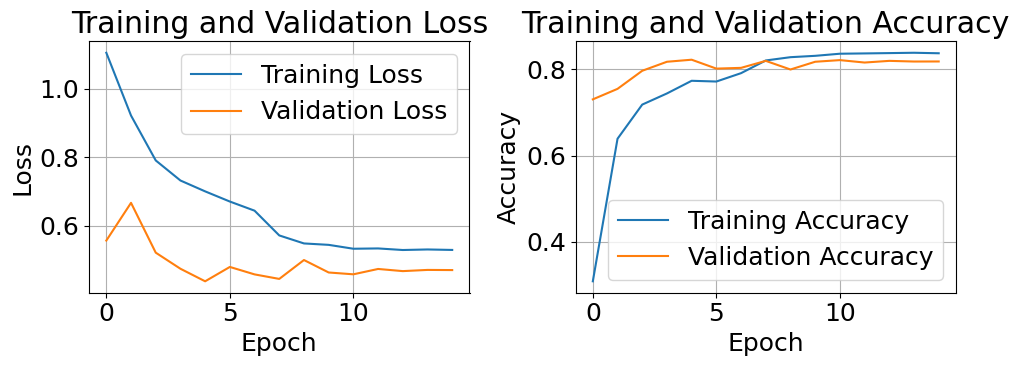

In [73]:
plot_history(history)

In [84]:
import pickle

model.save('lstm_model.h5')

# Save Tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [74]:
def build_model2(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.0, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(16, recurrent_dropout=0.0, dropout=0.5)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [76]:
batch_size = 64

model2 = build_model2(vocab_size, MAX_SEQUENCE_LENGTH)

history = model2.fit(X_train_seq, Y_train_seq, 
                    class_weight=class_weights, 
                    epochs=25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ])

y_pred = model2.predict(X_test_seq)
print('Accuracy:', accuracy_score(Y_test_seq, y_pred.round()))
print('F1 score:', f1_score(Y_test_seq, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test_seq, y_pred.round()))
print(classification_report(Y_test_seq, y_pred.round())) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 32)            3235872   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 32, 32)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 32, 64)            16640     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 512)               16896     
                                                      

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



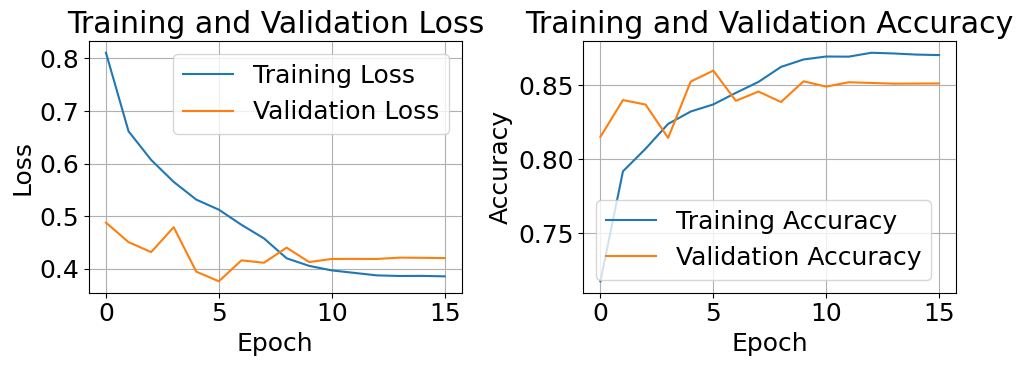

In [77]:
plot_history(history)

In [78]:
def build_model3(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
#     model.add(SpatialDropout1D(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#     model.add(GlobalMaxPooling1D())
    model.add(Bidirectional(LSTM(16, recurrent_dropout=0.0)))
    model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [79]:
batch_size = 32
model3 = build_model3(vocab_size, MAX_SEQUENCE_LENGTH)

print("class_weights: ", class_weights)
history = model3.fit(X_train_seq, Y_train_seq, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 7, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model3.predict(X_test_seq)
print('Accuracy:', accuracy_score(Y_test_seq, y_pred.round()))
print('F1 score:', f1_score(Y_test_seq, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test_seq, y_pred.round()))
print(classification_report(Y_test_seq, y_pred.round())) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 32)            3235872   
                                                                 
 conv1d (Conv1D)             (None, 28, 128)           20608     
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3276195 (12.50 MB)
Trainable params: 3276195 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
______________

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



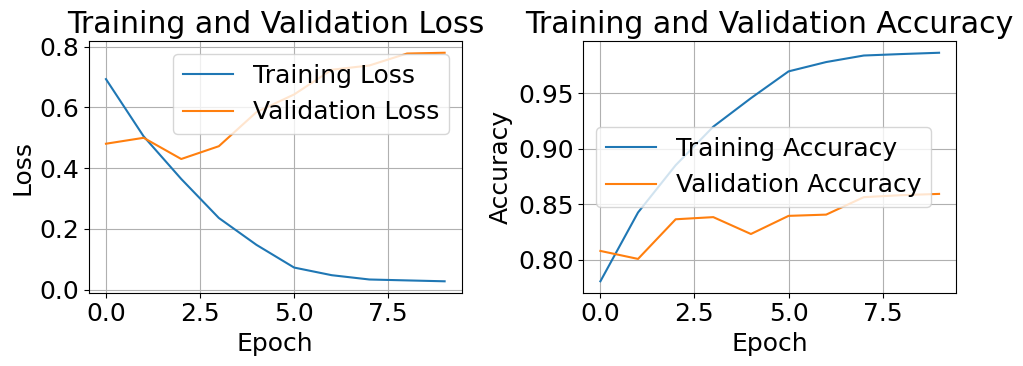

In [80]:
plot_history(history)

In [81]:
def build_model4(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
#     model.add(SpatialDropout1D(0.5))
    model.add(Bidirectional(GRU(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(16, recurrent_dropout=0.0)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [82]:
batch_size = 64

model4 = build_model4(vocab_size, MAX_SEQUENCE_LENGTH)

print("class_weights: ", class_weights)
history = model4.fit(X_train_seq, Y_train_seq, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 20, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 7, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model4.predict(X_test_seq)
print('Accuracy:', accuracy_score(Y_test_seq, y_pred.round()))
print('F1 score:', f1_score(Y_test_seq, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test_seq, y_pred.round()))
print(classification_report(Y_test_seq, y_pred.round())) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            3235872   
                                                                 
 bidirectional_5 (Bidirecti  (None, 32, 64)            12672     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3260067 (12.44 MB)
Trainable params: 326

c:\Users\artur\anaconda3\envs\myML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



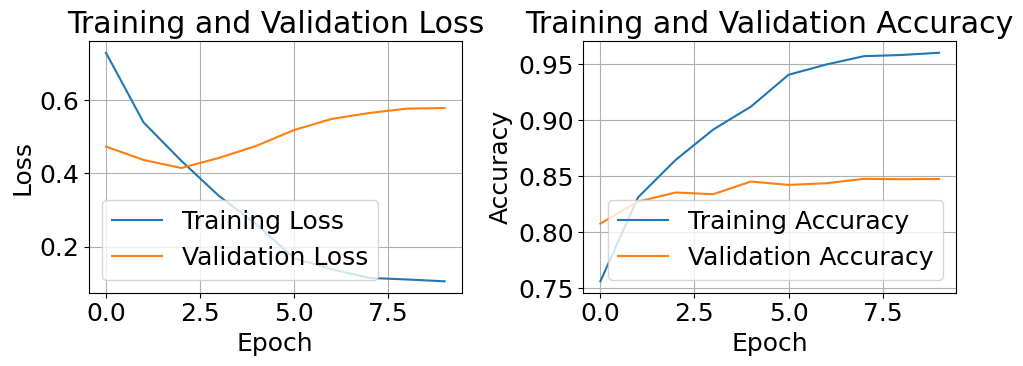

In [83]:
plot_history(history)

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)